In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.stats import t
import scipy.stats as stats
from scipy import io
import sympy as sp
import sys
import os
sys.path.append('../hw1')  # Add the directory containing heat_rod.py 
from heat_rod import SteadyStateRod


In [3]:
data_7p7 = io.loadmat('exercise_7p7_data.mat')

data = data_7p7['copper_data']  
x = data[:, 0]        # position (cm)
y_obs = data[:, 1]    # temperature (°C)

L = x.max()
k = 4.01  # W/cm/°C
data_7p7
x_data = data[:, 0]        # position (cm)
T_data = data[:, 1]        # temperature (°C)

In [4]:
# Model parameters for copper
a = 0.95  # cm
b = 0.95  # cm
L = 70.0  # cm
Tamb = 21.29  # °C
k = 4.01  # W/cm°C for copper (different from aluminum's 2.37)

# Initial parameter guesses
Phi_guess = -10.
h_guess = 0.001

# Create rod object with initial guesses
rod = SteadyStateRod(a=a, b=b, h_val=h_guess, k_val=k, 
                     Phi_val=Phi_guess, Tamb_val=Tamb, L=L)

# Define the model function using the rod class
def model_func(params, x):
    """Model for steady-state temperature distribution"""
    Phi, h = params
    return rod.Ts(x, h=h, Phi=Phi)

def residuals(params, x, y):
    return model_func(params, x) - y

# Perform least squares optimization
result = least_squares(residuals, [Phi_guess, h_guess], args=(x_data, T_data))
Phi_star, h_star = result.x

print("=" * 70)
print("COPPER ROD PARAMETER ESTIMATION")
print("=" * 70)
print(f"Optimal parameters:")
print(f"Phi* = {Phi_star:.4f} W/cm²")
print(f"h* = {h_star:.6f} W/cm²°C")

T_pred = model_func([Phi_star, h_star], x_data)

residuals_val = T_data - T_pred

n = len(x_data)  # 15
p = 2  # number of parameters
SSE = np.sum(residuals_val**2)
MSE = SSE / (n - p)  # Mean squared error
sigma = np.sqrt(MSE)  # Residual standard error

print(f"\nError statistics:")
print(f"Residual sum of squares (SSE): {SSE:.4f}")
print(f"Mean squared error (MSE) = {MSE:.4f}")
print(f"Residual standard error σ = {sigma:.4f} °C")

COPPER ROD PARAMETER ESTIMATION
Optimal parameters:
Phi* = -9.6110 W/cm²
h* = 0.001329 W/cm²°C

Error statistics:
Residual sum of squares (SSE): 0.3581
Mean squared error (MSE) = 0.0275
Residual standard error σ = 0.1660 °C


In [5]:
#  Calculate sensitivity matrix X (Jacobian) using the rod class
# X has dimensions n × p, where p=2 (Phi, h)
X = np.zeros((n, 2))

# Get sensitivity derivatives at optimal parameters
dT_dPhi = rod.dTs_dPhi(x_data, h=h_star, Phi=Phi_star)
dT_dh = rod.dTs_dh(x_data, h=h_star, Phi=Phi_star)

X[:, 0] = dT_dPhi  # Column for Phi
X[:, 1] = dT_dh    # Column for h

# Compute covariance matrix
XtX = X.T @ X
XtX_inv = np.linalg.inv(XtX)
var_b = MSE * XtX_inv  # Covariance matrix
std_b = np.sqrt(np.diag(var_b))  # Standard errors

print(f"\nCovariance matrix:")
print("V = ")
print(var_b)

print(f"\nStandard errors:")
print(f"σ_Φ = {std_b[0]:.4f}")
print(f"σ_h = {std_b[1]:.8f}")

z_critical = stats.norm.ppf(0.975)  # 1.96
CI_95 = np.column_stack([
    np.array([Phi_star, h_star]) - z_critical * std_b,
    np.array([Phi_star, h_star]) + z_critical * std_b
])

print("\n" + "=" * 70)
print("95% CONFIDENCE INTERVALS (z = 1.96, normal approximation)")
print("=" * 70)
print(f"{'Parameter':<10} {'Lower Bound':<15} {'Upper Bound':<15}")
print("-" * 70)
print(f"{'Φ':<10} {CI_95[0, 0]:<15.4f} {CI_95[0, 1]:<15.4f}")
print(f"{'h':<10} {CI_95[1, 0]:<15.8f} {CI_95[1, 1]:<15.8f}")

# Also calculate 2-sigma intervals (approximately 95% for large n)
print("\n" + "=" * 70)
print("2-SIGMA CONFIDENCE INTERVALS (~95.4% for normal)")
print("=" * 70)
CI_2sigma = np.column_stack([
    np.array([Phi_star, h_star]) - 2 * std_b,
    np.array([Phi_star, h_star]) + 2 * std_b
])
print(f"{'Parameter':<10} {'Lower Bound':<15} {'Upper Bound':<15}")
print("-" * 70)
print(f"{'Φ':<10} {CI_2sigma[0, 0]:<15.4f} {CI_2sigma[0, 1]:<15.4f}")
print(f"{'h':<10} {CI_2sigma[1, 0]:<15.8f} {CI_2sigma[1, 1]:<15.8f}")



Covariance matrix:
V = 
[[ 4.12115156e-03 -5.35583166e-07]
 [-5.35583166e-07  7.52299545e-11]]

Standard errors:
σ_Φ = 0.0642
σ_h = 0.00000867

95% CONFIDENCE INTERVALS (z = 1.96, normal approximation)
Parameter  Lower Bound     Upper Bound    
----------------------------------------------------------------------
Φ          -9.7369         -9.4852        
h          0.00131225      0.00134625     

2-SIGMA CONFIDENCE INTERVALS (~95.4% for normal)
Parameter  Lower Bound     Upper Bound    
----------------------------------------------------------------------
Φ          -9.7394         -9.4826        
h          0.00131190      0.00134660     


# 3.2

In [6]:
residuals = T_data - T_pred  # υ - y(q)
RMS_residuals = np.sqrt(np.mean(residuals**2))

print("\n" + "=" * 70)
print("RESIDUAL ANALYSIS")
print("=" * 70)
print(f"Root-Mean-Square (RMS) of residuals: {RMS_residuals:.6f} °C")



RESIDUAL ANALYSIS
Root-Mean-Square (RMS) of residuals: 0.154520 °C


# 3.3


In [13]:
sigma_obs = np.sqrt(MSE)  

# Estimated standard deviations from sampling distribution (parameter std errors)
sigma_Phi = std_b[0]
sigma_h = std_b[1]

print("\n" + "=" * 70)
print("3.3) ESTIMATED STANDARD DEVIATIONS")
print("=" * 70)
print(f"\nA) Standard Deviation of Observation Errors:")
print(f"   σ_obs = = √({MSE:.6f})")
print(f"         = {sigma_obs:.6f} °C")
print(f"   Typical magnitude of measurement/observation error")

print(f"\nB) Standard Deviations from Sampling Distribution (Parameter Uncertainty):")
print(f"   σ_Φ (for Φ) = {sigma_Phi:.6f} W/cm²")
print(f"   σ_h (for h) = {sigma_h:.10f} W/cm²°C")
print(f"   Uncertainty in estimated parameters due to limited data")


3.3) ESTIMATED STANDARD DEVIATIONS

A) Standard Deviation of Observation Errors:
   σ_obs = = √(0.027550)
         = 0.165981 °C
   Typical magnitude of measurement/observation error

B) Standard Deviations from Sampling Distribution (Parameter Uncertainty):
   σ_Φ (for Φ) = 0.064196 W/cm²
   σ_h (for h) = 0.0000086735 W/cm²°C
   Uncertainty in estimated parameters due to limited data


# 3.4

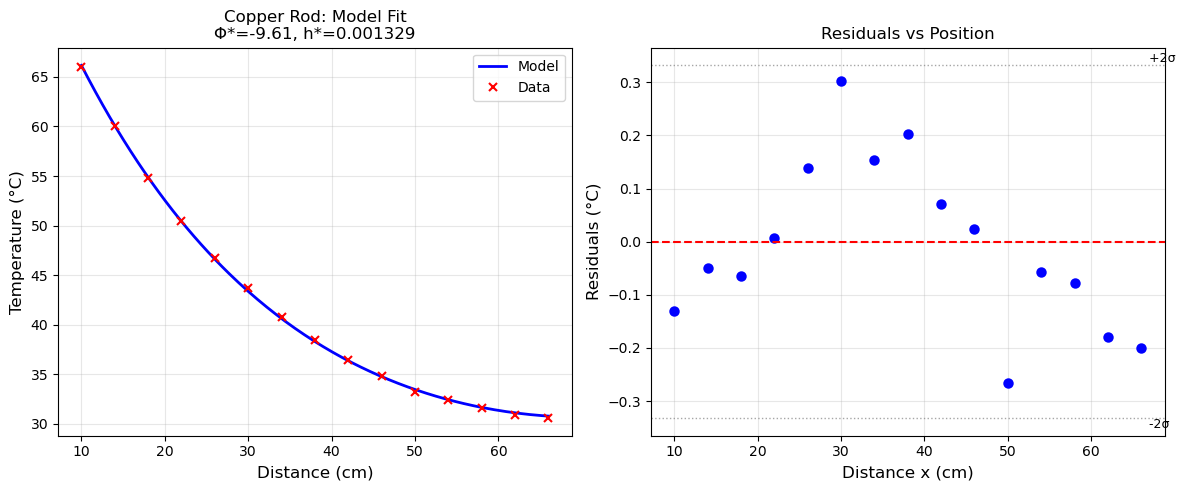

In [8]:

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Model fit
ax1 = axes[0]
x_fine = np.linspace(10, 66, 200)
T_fine = model_func([Phi_star, h_star], x_fine)

ax1.plot(x_fine, T_fine, 'b-', label='Model', linewidth=2)
ax1.plot(x_data, T_data, 'rx', markersize=6, markeredgewidth=1.5, label='Data')
ax1.set_xlabel('Distance (cm)', fontsize=12)
ax1.set_ylabel('Temperature (°C)', fontsize=12)
ax1.set_title(f'Copper Rod: Model Fit\nΦ*={Phi_star:.2f}, h*={h_star:.6f}', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals vs x
ax2 = axes[1]
ax2.plot(x_data, residuals_val, 'bo', markersize=6, markeredgewidth=1.5)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
ax2.set_xlabel('Distance x (cm)', fontsize=12)
ax2.set_ylabel('Residuals (°C)', fontsize=12)
ax2.set_title('Residuals vs Position', fontsize=12)
ax2.grid(True, alpha=0.3)

# Add ±2σ bands to residuals plot
ax2.axhline(y=2*sigma, color='gray', linestyle=':', linewidth=1, alpha=0.7)
ax2.axhline(y=-2*sigma, color='gray', linestyle=':', linewidth=1, alpha=0.7)
ax2.text(x_data[-1], 2*sigma, '  +2σ', fontsize=9, verticalalignment='bottom')
ax2.text(x_data[-1], -2*sigma, '  -2σ', fontsize=9, verticalalignment='top')

plt.tight_layout()
plt.show()
